#  Lab 07 - Knowledge Tracing

## Introduction

During the last lectures and lab session, you have dealt into one notable application of machine learning in education, namely knowledge tracing. Machine-learning models optimized for this task aim to understand how well a student is learning a portfolio of skills. Monitoring this knowledge by means of automated models allows to personalize online learning platforms, focusing the assessment on skills the student is weak in and accelerating learning of certain skills.

You are asked to work on the ASSISTment data set presented last week and to complete the following tasks:

- Compare three knowledge tracing models (BKT, AFM, PFA) in terms of AUC and RMSE.
- Generate and discuss the learning curves for a BKT model on a specific set of skills. 

You can use [pyBKT](https://github.com/CAHLR/pyBKT) and [pyAFM](https://github.com/cmaclell/pyAFM/) throughout this tutorial.


In [2]:
# Principal package imports
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as sc

# Scikit-learn package imports
from sklearn import feature_extraction, model_selection, metrics

# PyBKT package imports
from pyBKT.models import Model

# PyAFM package imports
# from pyafm.custom_logistic import CustomLogistic

### YOUR ADDITIONAL IMPORT STATEMENTS BELOW (please, do not make any imports elsewhere in the notebook) ###

## The Data Set
---

ASSISTments is a free tool for assigning and assessing math problems and homework. Teachers can select and assign problem sets. Once they get an assignment, students can complete it at their own pace and with the help of hints, multiple chances, and immediate feedback. Teachers get instant results broken down by individual student or for the whole class. More information on the platform can be found [here](https://www.commonsense.org/education/website/assistments). 

In this homework, we will play with a simplified version of a dataset collected from the ASSISTments tool, saved in a CSV file with the following columns:  


| Name                   | Description                         |
| ---------------------- | ------------------------------------------------------------ |
| user_id | The ID of the student who is solving the problem.  | |
| order_id | The temporal ID (timestamp) associated with the student's answer to the problem.  | |
| problem_id | The ID of the problem.  | |
| skill_name | The name of the skill associated with the problem. | |
| correct | The student's performance on the problem: 1 if the problem's answer is correct at the first attempt, 0 otherwise. 
| prior_success | The number of prior problems on that skill the student correctly answered at the first attempt. 
| prior_failure | The number of prior problems on that skill the student wrongly answered at the first attempt.  | |

Load the data set. 

In [3]:
# DATA_DIR = "./../../data/"
DATA_DIR = "./../../data/"
data = pd.read_csv(DATA_DIR + 'as_hw_cmp.csv')


Compute the total number of interactions, the number of unique students, and the number of unique skills

In [4]:
### YOUR CODE HERE ###
# total number of interactions
data.shape[0]

26409

In [5]:
# number of unique students
data['user_id'].nunique()

1014

In [6]:
# number of unique skills
data['skill_name'].nunique()

3

What are those skills?

In [7]:
data['skill_name'].unique()

array(['Circle Graph', 'Venn Diagram', 'Mode'], dtype=object)

In [8]:
data.head()

,user_id,order_id,problem_id,skill_name,correct,prior_success,prior_failure
0,14,21617623,93383,Circle Graph,0,0,0
1,14,21617632,93407,Circle Graph,1,0,1
2,14,21617641,93400,Circle Graph,0,1,1
3,14,21617650,93419,Circle Graph,0,1,2
4,14,21617659,93420,Circle Graph,0,1,3


<a id="section1"></a>
## 1  Knowledge Tracing: Model Performance Comparison 
----

In this section, we ask you to evaluate (i) a Bayesian Knowledge Tracing (BKT) model, (ii) an Additive Factor Model (AFM), and (iii) a Performance Factor Analysis (PFA) model on the skills 'Circle Graph', 'Venn Diagram', and 'Mode', by performing a user-stratified 10-fold cross validation and monitoring the Root Mean Squared Error (RMSE) and the Area Under the ROC Curve (AUC) as performance metrics. Then, we ask you to visually report the RMSE and AUC scores achieved by the three student's models in the user-stratified 10-fold cross validation, in such a way that the models' performance can be easily and appropriately compared against each other.

For your convenience, you will be guided in completing this section through six main tasks:
- Task 1.1: Group k-fold initialization.
- Task 1.2: BKT evaluation.
- Task 1.3: AFM evaluation.
- Task 1.4: PFA evaluation.
- Task 1.5: Performance metrics plotting.
- Task 1.6: Performance metrics discussion. 

<a id="section1.1"></a>
### Task 1.1

Given that the main objective of this homework section is to evaluate three student's knowledge tracing models under a `user-stratified 10-fold cross validation`, in this task, we ask you to complete the body of a function named `create_iterator`. This function should create an iterator object able to split student's interactions included in `data` in `10 folds` such that the same student does not appear in multiple folds. To do so, you can appropriately initialize a scikit-learn's GroupKFold iterator with non-overlapping groups and returning the iterator, i.e., `model_selection.GroupKFold(...).split(...)`. 

For convenience, we present you an illustrative example assuming that (i) you have four data samples and that (ii) the first two data samples belong to group 0 and the last two data samples belong to group 2. The data samples associated with a group should not appear in multiple folds or, in other words, the data samples associated with a group should appear all in the same fold. Please, find below a way to use the scikit-learn's GroupKFold object to create folds that meet this property (here, we simulate this scenario by considering only a 2-fold creation strategy):

`X = np.array([[1, 2], [3, 4], [5, 6], [7, 8]])
y = np.array([1, 2, 3, 4])
groups = np.array([0, 0, 2, 2])
group_kfold = model_selection.GroupKFold(n_splits=2).split(X, y, groups)
`

Finally, we provide an illustrative example not related with the task on how this iterator can be then used to generate training and test folds:

`
for train_index, test_index in group_kfold:
    print('TRAIN:', train_index, 'TEST:', test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print(X_train, '-', X_test, '-', y_train, '-', y_test)
`

The above for loop generates the following output. It can be observed that the data samples belonging to a group all appear in the same fold, as expected. 

`TRAIN: [0 1] TEST: [2 3]
[[1 2] [3 4]] - [[5 6] [7 8]] - [1 2] - [3 4] 
`

`
TRAIN: [2 3] TEST: [0 1]
[[5 6] [7 8]] - [[1 2] [3 4]] - [3 4] - [1 2]
`

Please, find more information about the GroupKFold iterator in the [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupKFold.html) documentation.

In [9]:
from sklearn.model_selection import GroupKFold

def create_iterator(data):
    '''
    Create an iterator to split interactions in data in 10 folds, with the same student not appearing in multiple folds.
    :param data:        Dataframe with student's interactions.
    :return:            An initialized GroupKFold iterator.
    '''
    ### YOUR CODE HERE ###
    # get the unique students
    return GroupKFold().split(
        data,
        groups=data['user_id'].values
    ) 

Check outputs of this function and the properties of the iterator. Make sure that at each iteration: there no user_id in both train and test set(no overlap), all user_id in the dataset are contain in the train and test set (union), each user appears in the test set exactly once and other property you find usefull to check.

In [10]:
tested_user_ids = set()
for iteration, (train_index, test_index) in enumerate(create_iterator(data)):
    user_ids = data['user_id'].unique()
    train_user_ids = data.iloc[train_index]['user_id'].unique()
    test_user_ids = data.iloc[test_index]['user_id'].unique()
    assert set(train_user_ids) & set(test_user_ids) == set()
    assert len(set(train_user_ids).union(set(test_user_ids))) == len(user_ids)
    assert set(tested_user_ids) & set(test_user_ids) == set()
    tested_user_ids = tested_user_ids.union(set(test_user_ids))

<a id="section1.2"></a>
### Task 1.2

In this task, we ask you to evaluate a `BKT model` with all default parameters, namely `Model(seed=0)` in pyBKT, through a `user-stratified 10-fold cross-validation`, computing the following performance metrics: `RMSE` and `AUC`. To do so, you should use the `create_iterator` function, defined in Task 1.1, to create the training and test set for each fold, starting from the interactions in `data`. 

No plotting is needed, it is enough to print the scores for each metric in the cell.

Please, note that this task may require a long running time (e.g., about 40 to 90 minutes), depending on your implementation and device. Just as an indication, on a Dell XPS 13, one fold lasts around 7 minutes.

Look at the `BKT model` [documentation](https://github.com/CAHLR/pyBKT) 

In [11]:
### YOUR CODE HERE (please, feel free to add extra cells to solve this task, after this first one) ###
rmse_bkt, auc_bkt = [], []
for iteration, (train_index, test_index) in enumerate(create_iterator(data)):
    # Split data in training and test sets
    X_train, X_test = data.iloc[train_index], data.iloc[test_index]
    # Initialize the model
    model = Model(seed=0)
    # Fit the model
    %time model.fit(data=X_train)
    # Compute RMSE (use the model evaluation methods)
    train_rmse = model.evaluate(data=X_train, metric='rmse')
    test_rmse = model.evaluate(data=X_test, metric='rmse')
    rmse_bkt.append(test_rmse)
    # Compute AUC (use the model evaluation methods)
    train_auc = model.evaluate(data=X_train, metric='auc')
    test_auc = model.evaluate(data=X_test, metric='auc')
    auc_bkt.append(test_auc)
    # Print progress
    print('Iteration:', iteration, 'RMSE', (train_rmse, test_rmse), 'AUC', (train_auc, test_auc))

CPU times: user 94.8 ms, sys: 16.4 ms, total: 111 ms
Wall time: 65.1 ms
Iteration: 0 RMSE (0.36619750236465737, 0.3481831734135507) AUC (0.8756875668754807, 0.8706469242501271)
CPU times: user 72.9 ms, sys: 11.3 ms, total: 84.2 ms
Wall time: 48.2 ms
Iteration: 1 RMSE (0.36245808863639467, 0.3633580549694738) AUC (0.8767952540021025, 0.8719412926148202)
CPU times: user 94 ms, sys: 14.2 ms, total: 108 ms
Wall time: 60.2 ms
Iteration: 2 RMSE (0.36489763371448947, 0.36079382603326854) AUC (0.8747590370860018, 0.8792324329510226)
CPU times: user 89.2 ms, sys: 11.8 ms, total: 101 ms
Wall time: 56 ms
Iteration: 3 RMSE (0.3613552200814039, 0.37843208644327314) AUC (0.8726190306728574, 0.8811831141455078)
CPU times: user 72.1 ms, sys: 11.2 ms, total: 83.2 ms
Wall time: 50.3 ms
Iteration: 4 RMSE (0.3611268105997534, 0.3688829650102705) AUC (0.8793098668116495, 0.8662834099291097)


Compute the mean and standard deviation for both metrics

In [12]:
rmse_bkt_mean, rmse_bkt_std = np.mean(rmse_bkt), np.std(rmse_bkt)
auc_bkt_mean, auc_bkt_std = np.mean(auc_bkt), np.std(auc_bkt)
print(f"RMSE: mean {rmse_bkt_mean} | std {rmse_bkt_std}")
print(f"AUC: mean {auc_bkt_mean} | std {auc_bkt_std}")

RMSE: mean 0.36393002117396733 | std 0.00992942726858043
AUC: mean 0.8738574347781174 | std 0.005547990890515791


<a id="section1.3"></a>
### Task 1.3

In this task, we ask you to evaluate an `AFM model` with all default parameters (e.g., no custom bounds, default l2 regularization, and fit_intercept=True) through a `user-stratified 10-fold cross-validation`, computing the following performance metrics: `RMSE` and `AUC`. To do so, exactly as you should have done for the BKT model in Task 1.2, you should use the `create_iterator` function, defined in Task 1.1, to create the training and test set for each fold, starting from the interactions in `data`. 

No plotting is needed, it is enough to print the scores for each metric in the cell.

The following cells include some utility functions that are needed to generate the `X` and `y` data in a format that is accepted by pyAFM model objects. To complete this task, you can build on top of the `X` and `y` created for you with the following cells. Please, refer to Tutorial 6 for further information on pyAFM. 

Take a look [here](https://github.com/cmaclell/pyAFM/blob/6150afdef7ab2eabff6c439accb5f9f81af34129/afms_workflow_predict.py#L11) to have ideas on how to use the `AFM model`

In [13]:
def read_as_student_step(data):    
    skills, opportunities, corrects, user_ids = [], [], [], []
    
    for row_id, (_, row) in enumerate(data.iterrows()):
        
        # Get attributes for the current interaction 
        user_id = row['user_id']
        skill_name = row['skill_name']
        correct = row['correct']
        prior_success = row['prior_success']
        prior_failure = row['prior_failure']
        
        # Update the number of opportunities this student had with this skill
        opportunities.append({skill_name: prior_success + prior_failure})
        
        # Update information in the current 
        skills.append({skill_name: 1})

        # Answer info
        corrects.append(correct)
        
        # Student info
        user_ids.append({user_id: 1})
        
    return (skills, opportunities, corrects, user_ids)

In [14]:
def prepare_data_afm(skills, opportunities, corrects, user_ids):

    sv = feature_extraction.DictVectorizer()
    qv = feature_extraction.DictVectorizer()
    ov = feature_extraction.DictVectorizer()
    S = sv.fit_transform(user_ids)
    Q = qv.fit_transform(skills)
    O = ov.fit_transform(opportunities)
    X = sc.sparse.hstack((S, Q, O))
    y = np.array(corrects)

    return (X.toarray(), y)

Prepare the X and y arrays to be used to evaluate the AFM model. 

In [15]:
%time skills, opportunities, corrects, user_ids = read_as_student_step(data)
%time X, y = prepare_data_afm(skills, opportunities, corrects, user_ids)

CPU times: user 531 ms, sys: 7.64 ms, total: 539 ms
Wall time: 539 ms
CPU times: user 48.5 ms, sys: 15.3 ms, total: 63.8 ms
Wall time: 64.8 ms


In [16]:
X

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 2., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 2., 0.],
       [0., 0., 0., ..., 0., 3., 0.],
       [0., 0., 0., ..., 0., 4., 0.]])

In [17]:
### YOUR CODE HERE (please, feel free to add extra cells to solve this task, after this first one) ###
rmse_afm, auc_afm = [], []
for iteration, (train_index, test_index) in enumerate(create_iterator(data)):
    # Split data in training and test sets
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # Initialize and fit the model
    afm = CustomLogistic()
    %time afm.fit(X_train,y_train)
    # Make predictions 
    y_train_pred = afm.predict_proba(X_train)
    y_test_pred = afm.predict_proba(X_test)
    # Compute RMSE (use metrics package methods)
    train_rmse = metrics.mean_squared_error(y_train, y_train_pred, squared=False)
    test_rmse = metrics.mean_squared_error(y_test, y_test_pred, squared=False)
    rmse_afm.append(test_rmse)
    # Compute AUC (use metrics package methods)
    train_auc = metrics.roc_auc_score(y_train, y_train_pred)
    test_auc = metrics.roc_auc_score(y_test, y_test_pred)
    auc_afm.append(test_auc)
    # Print progress
    print('Iteration:', iteration, 'RMSE', (train_rmse, test_rmse), 'AUC', (train_auc, test_auc))

NameError: name 'CustomLogistic' is not defined

<a id="section1.4"></a>
### Task 1.4

In this task, we ask you to evaluate a `PFA model` with all default parameters (e.g., no custom bounds, default l2 regularization, and fit_intercept=True) through a `user-stratified 10-fold cross-validation`, computing the following performance metrics: `RMSE` and `AUC`. To do so, exactly as you should have done for the BKT and AFM models in Task 1.2 and 1.3, you should use the `create_iterator` function, defined in Task 1.1, to create the training and test set for each fold, starting from the interactions in `data`. 

No plotting is needed, it is enough to print the scores for each metric in the cell.

The following cells include some utility functions that are needed to generate the `X` and `y` data in a format that is accepted by pyAFM model objects. To complete this task, you can build on top of the `X` and `y` created for you with the following cells. Please, refer to Tutorial 6 for further information on pyAFM. 

In [18]:
def read_as_success_failure(data):
    n_succ, n_fail = [], []

    # Create the n_succ and n_fail variables required by pyAFM
    for i, row in data.iterrows():
        n_succ.append({row['skill_name']: int(row['prior_success'])})
        n_fail.append({row['skill_name']: int(row['prior_failure'])})
        
    return n_succ, n_fail

In [19]:
def prepare_data_pfa(skills, corrects, user_ids, n_succ, n_fail):
    
    s = feature_extraction.DictVectorizer()
    q = feature_extraction.DictVectorizer()
    succ = feature_extraction.DictVectorizer()
    fail = feature_extraction.DictVectorizer()
    S = s.fit_transform(user_ids)
    Q = q.fit_transform(skills)
    succ = succ.fit_transform(n_succ)
    fail = fail.fit_transform(n_fail)
    X = sc.sparse.hstack((S, Q, succ, fail))
    y = np.array(corrects)

    return (X.toarray(), y)

Prepare the X and y arrays to be used to evaluate the PFA model. 

In [20]:
%time n_succ, n_fail = read_as_success_failure(data)
%time X, y = prepare_data_pfa(skills, corrects, user_ids, n_succ, n_fail)

CPU times: user 498 ms, sys: 7.41 ms, total: 505 ms
Wall time: 504 ms
CPU times: user 64.8 ms, sys: 15.8 ms, total: 80.6 ms
Wall time: 80.7 ms


In [21]:
### YOUR CODE HERE (please, feel free to add extra cells to solve this task, after this first one) ###
rmse_pfa, auc_pfa = [], []
for iteration, (train_index, test_index) in enumerate(create_iterator(data)):
    # Split data in training and test sets
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # Initialize and fit the model
    pfa = CustomLogistic()
    %time pfa.fit(X_train, y_train)
    # Make predictions 
    y_train_pred = pfa.predict_proba(X_train)
    y_test_pred = pfa.predict_proba(X_test)
    # Compute RMSE
    train_rmse = metrics.mean_squared_error(y_train, y_train_pred, squared=False)
    test_rmse = metrics.mean_squared_error(y_test, y_test_pred, squared=False)
    rmse_pfa.append(test_rmse)
    # Compute AUC
    train_auc = metrics.roc_auc_score(y_train, y_train_pred)
    test_auc = metrics.roc_auc_score(y_test, y_test_pred)
    auc_pfa.append(test_auc)
    # Print progress
    print('Iteration:', iteration, 'RMSE', (train_rmse, test_rmse), 'AUC', (train_auc, test_auc))

NameError: name 'CustomLogistic' is not defined

<a id="section1.5"></a>
### Task 1.5

In this task, we ask you to visually report the RMSE and AUC scores achieved by the three student's models in the user-stratified 10-fold cross validation performed in Task 1.2, 1.3, and 1.4 respectively, in such a way that the models' performances can be easily and appropriately compared against each other. 

/var/folders/75/94jyvgc92_gcwmzgrg36xfd00000gn/T/ipykernel_51770/3545205238.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(ax=axes[0],x='x', y='RMSE', data=rmse_all_data, estimator=np.mean, ci='sd')
/var/folders/75/94jyvgc92_gcwmzgrg36xfd00000gn/T/ipykernel_51770/3545205238.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(ax=axes[1],x='x', y='AUC', data=auc_all_data, estimator=np.mean, ci='sd')
/var/folders/75/94jyvgc92_gcwmzgrg36xfd00000gn/T/ipykernel_51770/3545205238.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


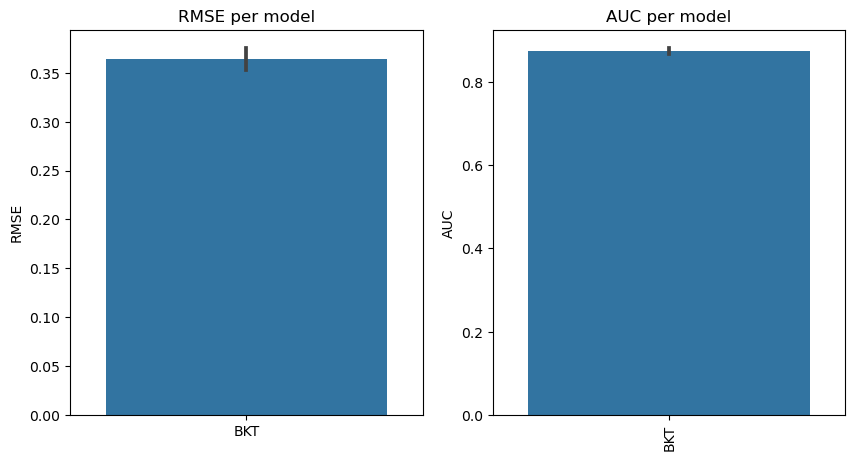

In [22]:
### YOUR CODE HERE (please, feel free to add extra cells to solve this task, after this first one) ###
rmse_all = rmse_bkt + rmse_afm + rmse_pfa
auc_all = auc_bkt + auc_afm + auc_pfa
models = ["BKT"]*5 + ["AFM"]*5 + ["PFA"]*5

rmse_all_data = pd.DataFrame(list(zip(models, rmse_all)),columns =['x', 'RMSE'])
auc_all_data = pd.DataFrame(list(zip(models, auc_all)),columns =['x', 'AUC'])

fig, axes = plt.subplots(1, 2, figsize=(10,5))

sns.barplot(ax=axes[0],x='x', y='RMSE', data=rmse_all_data, estimator=np.mean, ci='sd')
axes[0].set_title('RMSE per model')
axes[0].set_xlabel('')

sns.barplot(ax=axes[1],x='x', y='AUC', data=auc_all_data, estimator=np.mean, ci='sd')
plt.xticks(rotation=90)
axes[1].set_title('AUC per model')
axes[1].set_xlabel('')

fig.show()

### Task 1.6 Please compare and discuss the performance metric scores achieved by the student's models.

YOUR ANSWER HERE

<a id="section1"></a>
## 2  Knowledge Tracing: Learning Curves Comparison 
----

In this section, you should fit a Bayesian Knowledge Tracing (BKT) model on the three skills included in the `data` data set, and compute the corresponding predictions. Then, for each skill included in the data dataframe, you should visually report and discuss (i) the learning curve and (ii) the bar plot representing the number of students who reached a given number of opportunities for that skill, obtained through the BKT model fitted on that skill, in such a way that models' learning patterns can be easily and appropriately compared. No comparison with other baseline model is required.

For your convenience, you will be guided in completing this section through three main tasks:
- Task 2.1: BKT fit and prediction. 
- Task 2.2: Learning curves and bar plots generation.
- Task 2.3: Learning curves and bar plots discussion. 

<a id="section2.1"></a>
### Task 2.1

In this task, we ask you to fit a BKT model with all default parameters, i.e., `Model(seed=0)` in pyBKT, on the full `data` data set (no split into train and test set needed as we are not assessing predictive performance of the model here). Once your BKT model is fitted, we ask you to appropriately create a dataframe named `predictions` with four columns `user_id`, `skill_name`, `y_true`, `y_pred_bkt`. This dataframe should include one row per interaction in `data`, where user_id is the id of the student associated with that interaction, skill_name is the name of the skill involved in that interaction, y_true is the true student's performance on that interaction (1 if correct at the first attempt, 0 otherwise), and y_pred_bkt is the prediction made by the pre-trained BKT model for that interaction.  

Please, note that this task may require a long running time (e.g., about 10 to 20 minutes), depending on your implementation and device. Just as an indication, on a Dell XPS 13, the fit process lasts around 7 minutes.  

In [23]:
### YOUR CODE HERE (please, feel free to add extra cells to solve this task, after this first one) ###
# Initialize the model
model = Model(seed=0)

# Fit the model on the entire dataset
%time model.fit(data=data)

CPU times: user 88.8 ms, sys: 14.5 ms, total: 103 ms
Wall time: 60.9 ms


In [24]:
### YOUR CODE HERE ###
# Make predictions
predictions = model.predict(data=data)

# Rename the dataframe columns as per instructions
#predictions.columns = ['user_id', 'skill_name', 'y_true', 'y_pred_bkt']
predictions = predictions.rename(columns={
    'correct': 'y_true',
    'correct_predictions': 'y_pred_bkt'
})[['user_id','order_id','skill_name','y_true','y_pred_bkt']]
predictions

,user_id,order_id,skill_name,y_true,y_pred_bkt
0,14,21617623,Circle Graph,0,0.46306
1,14,21617632,Circle Graph,1,0.33503
2,14,21617641,Circle Graph,0,0.57399
3,14,21617650,Circle Graph,0,0.45390
4,14,21617659,Circle Graph,0,0.32737
...,...,...,...,...,...
24481,96298,38175812,Venn Diagram,1,0.68027
24482,96298,38175813,Venn Diagram,0,0.73047
6207,96298,38175828,Circle Graph,0,0.24713
26407,96298,38175955,Mode,1,0.92166


Print the first ten rows as a double check

In [25]:
predictions.head(10)

,user_id,order_id,skill_name,y_true,y_pred_bkt
0,14,21617623,Circle Graph,0,0.46306
1,14,21617632,Circle Graph,1,0.33503
2,14,21617641,Circle Graph,0,0.57399
3,14,21617650,Circle Graph,0,0.45390
4,14,21617659,Circle Graph,0,0.32737
5,14,21617667,Circle Graph,0,0.24293
6,14,21617675,Circle Graph,0,0.20228
7,14,21617692,Circle Graph,0,0.18578
8,14,21617731,Circle Graph,1,0.17955
9,14,21617749,Circle Graph,0,0.36123


<a id="section2.4"></a>
### Task 2.2

In this task, for each skill, we ask you to visually report and discuss (i) the `learning curve` and (ii) the `bar plot` representing the number of students who reached a given number of opportunities (similar to the visualizations done in Tutorial 6),  obtained by the BKT model fitted on that skill, in such a way that models' learning patterns can be easily and appropriately compared. To do so, we ask you to use the predictions you stored in the dataframe `predictions`.    

No comparison with other baseline model is required.

Please, refer to Tutorial 6 for further information on learning curve and bar plotting for student's knowledge tracing models.

In [30]:
predictions_for_skill = predictions[predictions.skill_name == 'Circle Graph']
predictions_for_skill_grouped_by_user = predictions_for_skill.groupby('user_id').aggregate({
    'y_true': list,
    'y_pred_bkt': list,
}).reset_index()
# For each row, the y_true column is a list. Filter rows that have only one element in the list.
predictions_for_skill_grouped_by_user[predictions_for_skill_grouped_by_user.y_true.apply(lambda x: len(x) == 1)]

,user_id,y_true,y_pred_bkt
3,70677,[0],[0.46306396268163247]
9,70708,[0],[0.46306396268163247]
12,70730,[1],[0.46306396268163247]
18,70745,[1],[0.46306396268163247]
27,71557,[1],[0.46306396268163247]
...,...,...,...
524,89215,[1],[0.46306396268163247]
529,91448,[1],[0.46306396268163247]
531,91676,[0],[0.46306396268163247]
532,91749,[0],[0.46306396268163247]


Done!!
Done!!
Done!!


/var/folders/75/94jyvgc92_gcwmzgrg36xfd00000gn/T/ipykernel_51770/518176857.py:37: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


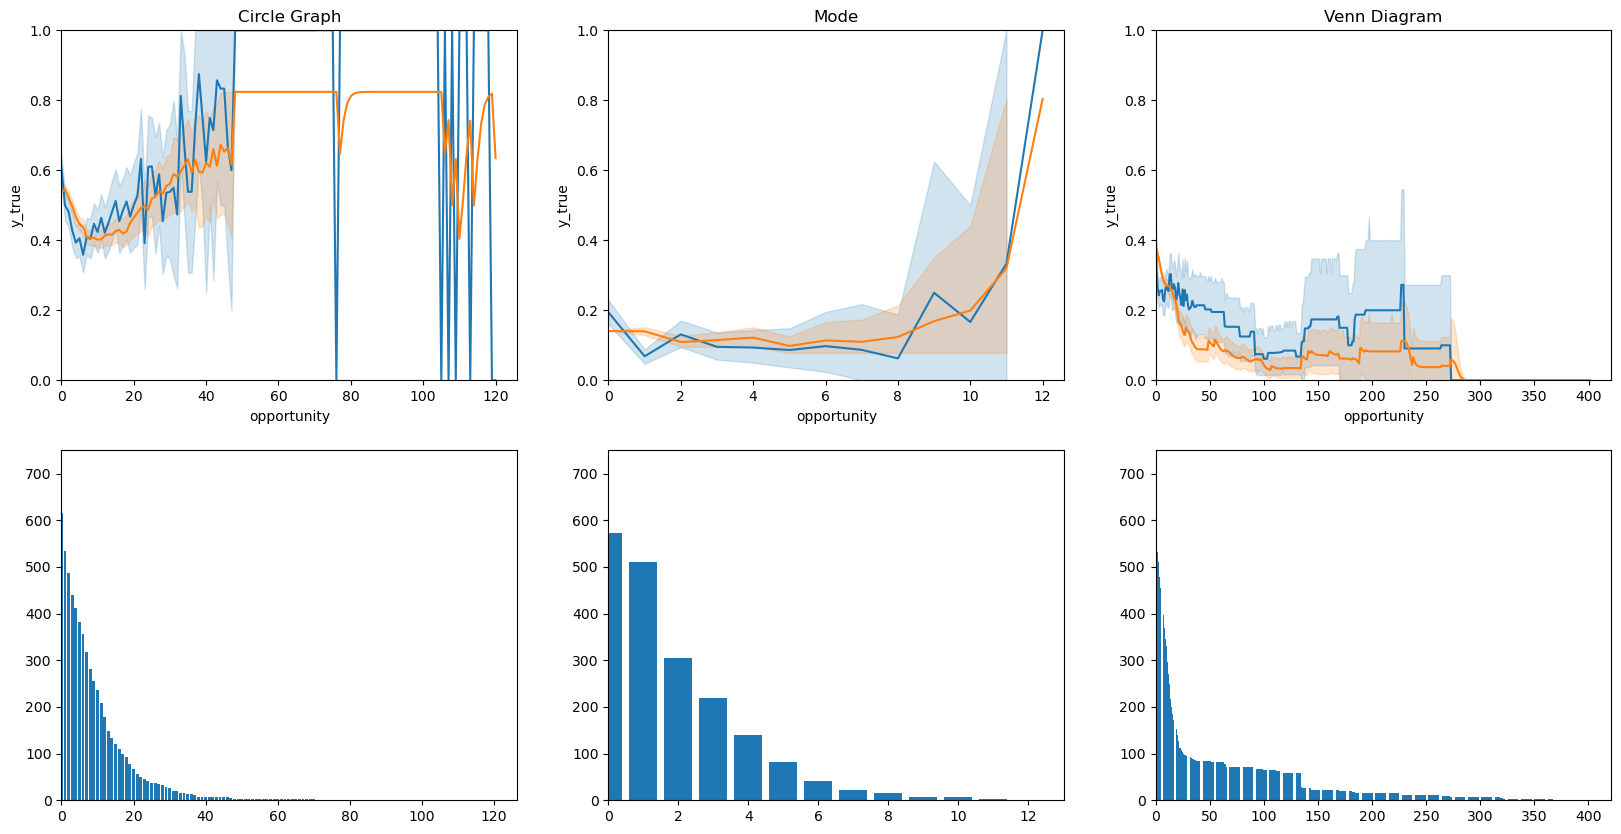

In [31]:
skills = predictions.skill_name.unique()
fig, axes = plt.subplots(2, len(skills), figsize=(20,10))
for index,skill in enumerate(skills):
    predictions_for_skill = predictions[predictions.skill_name == skill]
    predictions_for_skill_grouped_by_user = predictions_for_skill.groupby('user_id').aggregate({
        'y_true': list,
        'y_pred_bkt': list,
    }).reset_index()
    opportunity = 0
    pred_vals_per_opportunity = []
    y_true_vals_per_opportunity = []
    lens_per_opportunity = []
    while True:
        # filter out users who don't have this much opportunity
        filtered_users = predictions_for_skill_grouped_by_user[predictions_for_skill_grouped_by_user.y_true.apply(lambda x: len(x) > opportunity)]
        y_true_vals = filtered_users.y_true.apply(lambda x: x[opportunity]).values
        y_pred_vals = filtered_users.y_pred_bkt.apply(lambda x: x[opportunity]).values
        if len(y_true_vals) == 0:
            print("Done!!")
            break
        y_true_vals_per_opportunity += list(map(lambda x: (opportunity,x), y_true_vals))
        pred_vals_per_opportunity += list(y_pred_vals)
        lens_per_opportunity.append(len(y_true_vals))
        opportunity += 1
    data_df = pd.DataFrame(y_true_vals_per_opportunity, columns=['opportunity', 'y_true'])
    data_df['y_pred'] = pred_vals_per_opportunity
    data_df['y_true'] = data_df['y_true'].apply(lambda x: 1-x)
    data_df['y_pred'] = data_df['y_pred'].apply(lambda x: 1-x)
    sns.lineplot(ax=axes[0, index],x='opportunity', y='y_true', data=data_df, estimator=np.mean, errorbar='ci')
    sns.lineplot(ax=axes[0, index],x='opportunity', y='y_pred', data=data_df, estimator=np.mean, errorbar='ci')
    axes[0, index].set_title(skill)
    axes[0, index].set_ylim(0, 1)
    axes[0, index].set_xlim(0, None)
    axes[1,index].bar([i for i in range(opportunity)], lens_per_opportunity)
    axes[1, index].set_ylim(0, 750)
    axes[1, index].set_xlim(0, None)
fig.show()

Done!!


/var/folders/75/94jyvgc92_gcwmzgrg36xfd00000gn/T/ipykernel_51770/1713790087.py:40: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Done!!


/var/folders/75/94jyvgc92_gcwmzgrg36xfd00000gn/T/ipykernel_51770/1713790087.py:40: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Done!!


/var/folders/75/94jyvgc92_gcwmzgrg36xfd00000gn/T/ipykernel_51770/1713790087.py:40: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


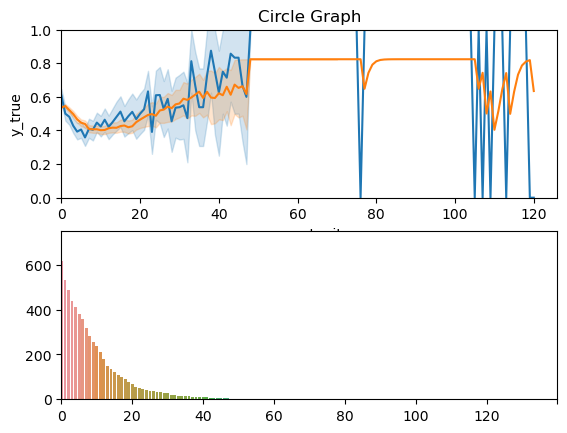

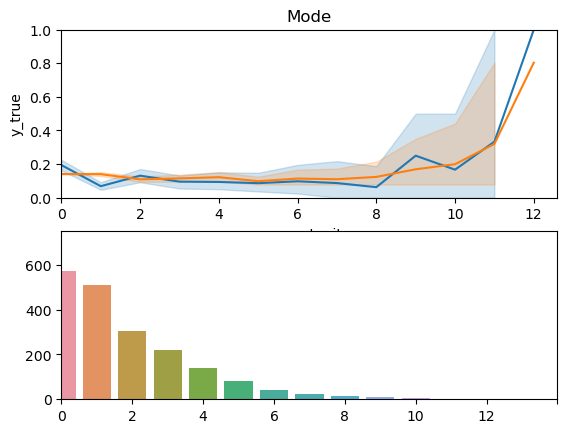

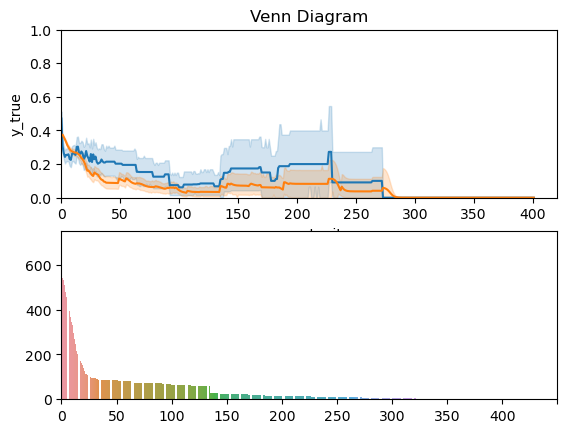

In [46]:
skills = predictions.skill_name.unique()
for index,skill in enumerate(skills):
    fig, axes = plt.subplots(2, 1)
    predictions_for_skill = predictions[predictions.skill_name == skill]
    predictions_for_skill_grouped_by_user = predictions_for_skill.groupby('user_id').aggregate({
        'y_true': list,
        'y_pred_bkt': list,
    }).reset_index()
    opportunity = 0
    pred_vals_per_opportunity = []
    y_true_vals_per_opportunity = []
    lens_per_opportunity = []
    while True:
        # filter out users who don't have this much opportunity
        filtered_users = predictions_for_skill_grouped_by_user[predictions_for_skill_grouped_by_user.y_true.apply(lambda x: len(x) > opportunity)]
        y_true_vals = filtered_users.y_true.apply(lambda x: x[opportunity]).values
        y_pred_vals = filtered_users.y_pred_bkt.apply(lambda x: x[opportunity]).values
        if len(y_true_vals) == 0:
            print("Done!!")
            break
        y_true_vals_per_opportunity += list(map(lambda x: (opportunity,x), y_true_vals))
        pred_vals_per_opportunity += list(y_pred_vals)
        lens_per_opportunity.append(len(y_true_vals))
        opportunity += 1
    data_df = pd.DataFrame(y_true_vals_per_opportunity, columns=['opportunity', 'y_true'])
    data_df['y_pred'] = pred_vals_per_opportunity
    data_df['y_true'] = data_df['y_true'].apply(lambda x: 1-x)
    data_df['y_pred'] = data_df['y_pred'].apply(lambda x: 1-x)
    sns.lineplot(ax=axes[0],x='opportunity', y='y_true', data=data_df, estimator=np.mean, errorbar='ci')
    sns.lineplot(ax=axes[0],x='opportunity', y='y_pred', data=data_df, estimator=np.mean, errorbar='ci')
    axes[0].set_title(skill)
    axes[0].set_ylim(0, 1)
    axes[0].set_xlim(0, None)
    #axes[1].bar([i for i in range(opportunity)], lens_per_opportunity)
    sns.barplot(ax=axes[1],x=[i for i in range(opportunity)], y=lens_per_opportunity)
    axes[1].set_ylim(0, 750)
    axes[1].set_xlim(0, None)
    # make ticks of the x-axis of bar plot to be the same as the x-axis of the line plot
    axes[1].set_xticks(axes[0].get_xticks())
    fig.show()

### Task 2.3 Please discuss all visualizations (learning curves and bar plots) obtained with the BKT model. 

In [38]:
data_df

,opportunity,y_true,y_pred
0,0,0,0.37402
1,0,1,0.37402
2,0,0,0.37402
3,0,1,0.37402
4,0,0,0.37402
...,...,...,...
18270,397,0,0.00002
18271,398,0,0.00002
18272,399,0,0.00002
18273,400,0,0.00002


YOUR ANSWER HERE